In [1]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [2]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [3]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [4]:
symbol = 'BTC/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [5]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [6]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver4.0 y el notebook es red_neuronal_mlp.ipynb


In [9]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver4.1')
from ft_transformer_model import torch,model, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind = df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

# Preparar los nuevos datos
X_nuevos = df_ind[features]
X_nuevos = X_nuevos.dropna()

# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

# Convertir los datos a tensores de PyTorch
X_nuevos_tensor = torch.tensor(X_nuevos_scaled, dtype=torch.float32)

# Realizar predicciones en los nuevos datos
model.eval()  # Establecer el modelo en modo de evaluación (desactiva el dropout y batch normalization)
with torch.no_grad():  # Desactivar el cálculo de gradientes
    outputs = model(X_nuevos_tensor)  # Obtener las salidas del modelo
    predicciones = torch.argmax(outputs, dim=1)  # Obtener las predicciones (la clase con mayor probabilidad)

# Añadir las predicciones al DataFrame
df_df_ind = df_df_ind.loc[X_nuevos.index]  # Asegura que coincidan los índices
df_df_ind["predicted_signals"] = predicciones.numpy()  # Convertir las predicciones a un array de numpy



In [21]:
import numpy as np

# Opcional: convertir las predicciones numéricas de vuelta a texto
inverse_mapping = {0: 'buy', 1: 'sell', 2: 'hold'}
df_df_ind['predictions_text'] = df_df_ind['predicted_signals'].map(inverse_mapping)

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predictions_text'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predictions_text'] == 'sell', 1, 0)


In [22]:
df_df_ind.head(n=60)

,date,open,high,low,close,volume,value,value_classification,rsi,macd,...,dri,dlogri,avgtr,donch_hband,donch_lband,vwap,predicted_signals,buy_signal,sell_signal,predictions_text
25,2022-08-01,23305.12,23499.48,22852.30,23265.44,2259.666522,39,Fear,58.527823,512.824738,...,-0.170263,-0.170408,1172.552177,24668.16,18911.04,22973.614432,2,0,0,hold
26,2022-08-02,23265.44,23450.00,22657.20,22978.10,2698.984857,33,Fear,55.527882,481.490984,...,-1.235051,-1.242741,1145.427022,24668.16,19625.76,22982.800492,2,0,0,hold
27,2022-08-03,22978.10,23638.46,22685.78,22819.37,2076.332526,31,Fear,53.884782,438.792448,...,-0.690788,-0.693185,1131.659377,24668.16,20383.34,22911.638924,2,0,0,hold
28,2022-08-04,22819.37,23217.02,22404.72,22617.74,2278.790470,34,Fear,51.788419,384.254250,...,-0.883591,-0.887518,1108.847993,24668.16,20473.64,22896.190238,2,0,0,hold
29,2022-08-05,22617.74,23475.53,22591.61,23308.31,2485.564815,30,Fear,57.838407,392.234133,...,3.053223,3.007540,1092.781708,24668.16,20710.36,22902.504779,2,0,0,hold
30,2022-08-06,23308.31,23346.86,22910.01,22951.20,985.864994,31,Fear,54.060411,365.528865,...,-1.532115,-1.543973,1045.929443,24668.16,20710.36,22932.242526,2,0,0,hold
31,2022-08-07,22951.20,23396.97,22850.00,23177.58,890.846902,31,Fear,56.021539,358.499167,...,0.986354,0.981521,1010.289483,24668.16,20710.36,22953.021168,2,0,0,hold
32,2022-08-08,23177.58,24240.60,23159.87,23815.45,2284.475576,30,Fear,61.065094,399.790325,...,2.752099,2.714910,1015.320948,24668.16,20710.36,23111.916567,2,0,0,hold
33,2022-08-09,23815.45,23926.69,22875.00,23150.39,1956.630895,30,Fear,54.098859,374.531712,...,-2.792557,-2.832290,1017.918738,24668.16,20710.36,23287.714032,2,0,0,hold
34,2022-08-10,23150.39,24221.92,22664.06,23952.14,3440.139455,42,Fear,60.020063,414.431299,...,3.463225,3.404605,1056.485971,24668.16,20710.36,23439.048476,2,0,0,hold


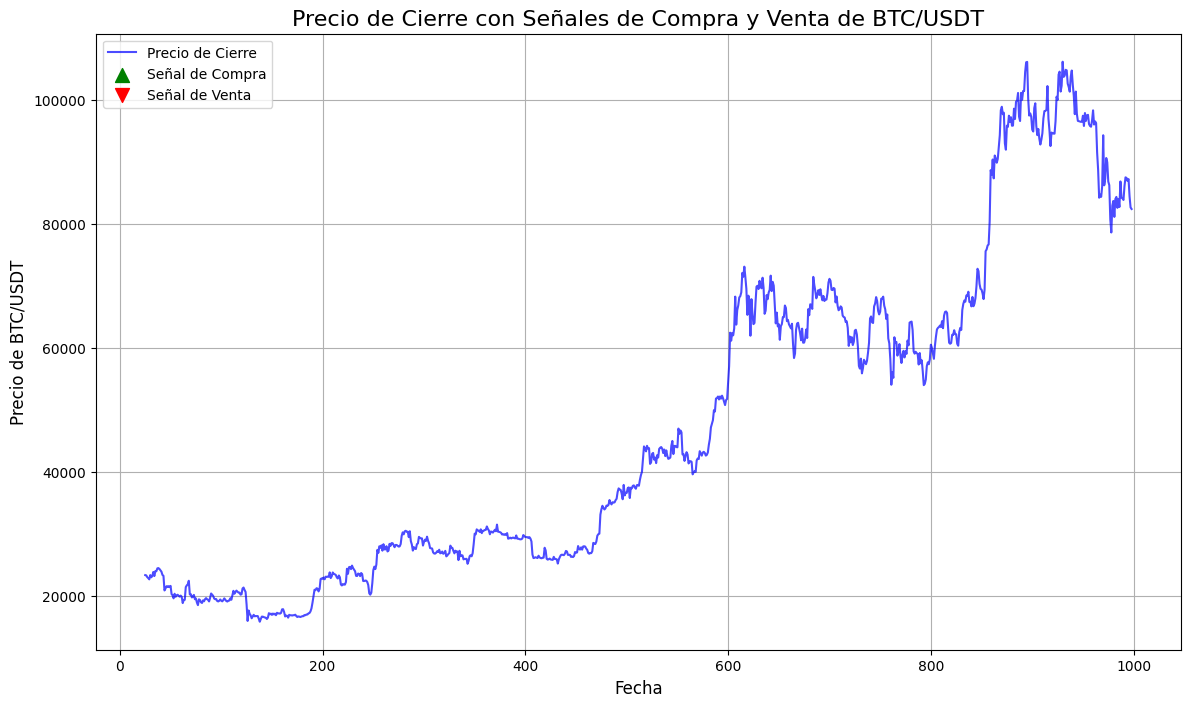

In [23]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title(f'Precio de Cierre con Señales de Compra y Venta de {symbol}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {symbol}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Capital final: 1000.00 USDT


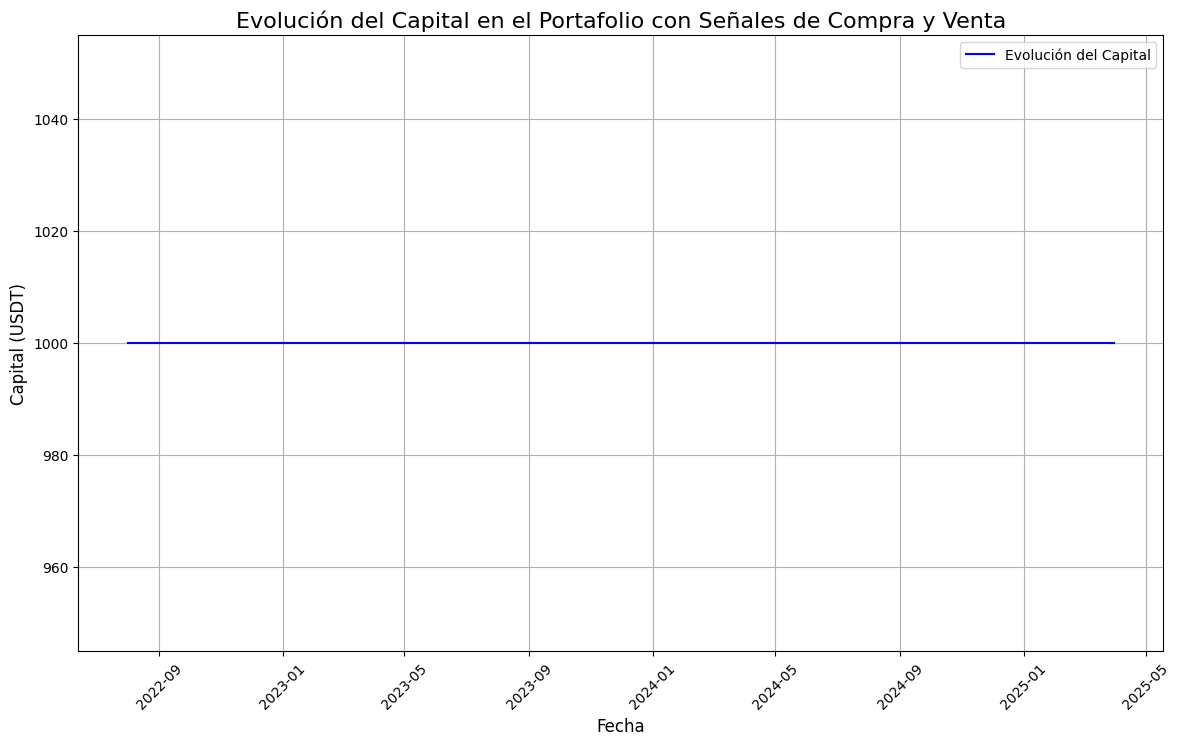

In [24]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 1000.00 USDT
Tasa de Retorno Acumulado: 0.00%
Volatilidad Anualizada: 0.4155
Relación de Sharpe: -0.0201
Drawdown Máximo: 0.00%


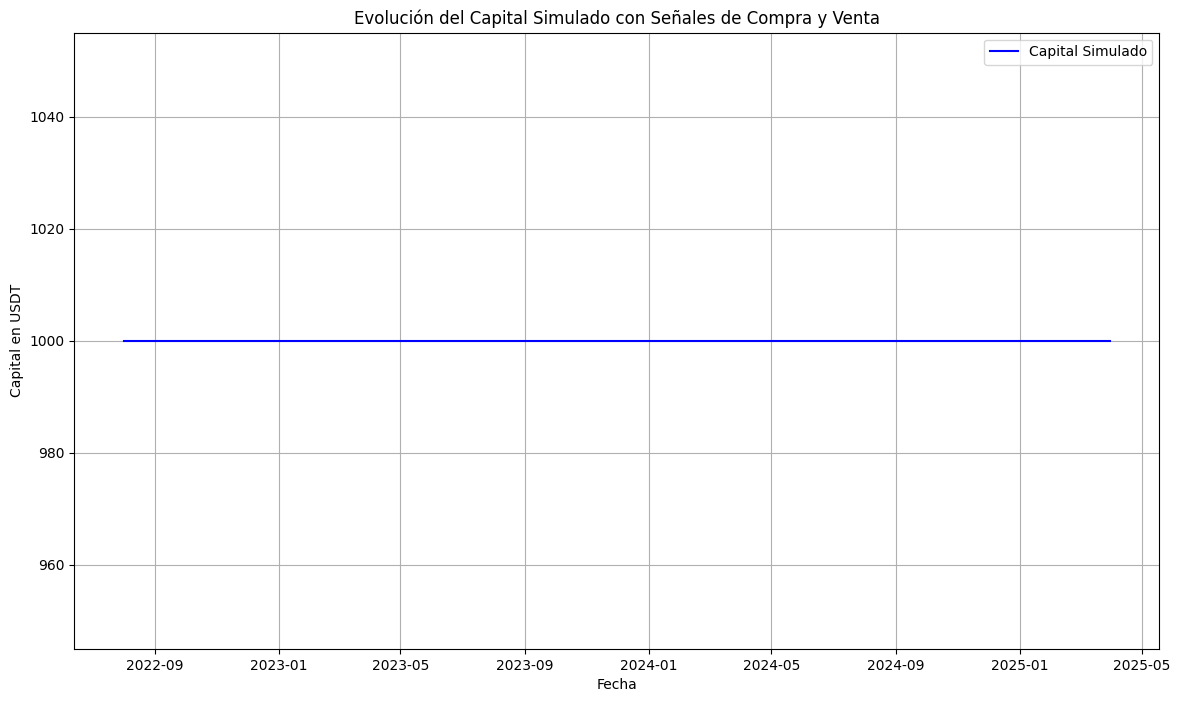

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [26]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Capital final: 1000.00 USDT
